Download html of wikipedias list of buisiest US airports

In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

url = "https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States"
response = urlopen(url)
html = response.read()
response.close()
soup = BeautifulSoup(html,"html.parser")
tables = soup.findAll("table")

Parse the HTML code to pull out the airport name, airport code, nearest city, and hyperlink the airports own wikipedia page. Store the name of the airports, its code, nearest city, and suffix link to its own wikipedia page in lists

In [3]:
airport_names = []
airport_cities = []
links = []
codes = []
code_exceptions = ['HNL','ANC','SJU','OGG'] #codes for airports outside the continental US which don't have a K prefix (important later)
for table in tables[:2]:
    for tr in table.findAll('tr')[1:]:
        for i,a in enumerate(tr.findAll('a')):
            if i == 0:
                airport_names.append(a.get_text()) #grabs the aiport and city info
                links.append(a['href']) # grabs the suffix needed to navigate to the airports wiki
            if i == 1: #only keep the first city if there is two
                airport_cities.append(a.get_text())
        nickname = tr.findAll('td')[2] #get the airport code
        nickname = nickname.get_text()
        if nickname not in code_exceptions:
            codes.append("K"+nickname) #append a K to the airport code if inside the continental US
        else:
            codes.append(nickname)

For each airport, go to the airports own wikipedia page to grab the latitude and longitude of the airport

In [4]:
wiki = "https://en.wikipedia.org"
latitudes = []
longitudes =[]
for link in links:
    response = urlopen(wiki+link)
    print("Gathering Data from:",link[6:])
    html = response.read()
    response.close()
    soup = BeautifulSoup(html,"html.parser")
    coords = soup.findAll("span",{"class":"geo"})
    lat_lon = coords[0].get_text()
    lat,lon = lat_lon.split(";")
    latitudes.append(float(lat))
    longitudes.append(float(lon))

Gathering Data from: Hartsfield%E2%80%93Jackson_Atlanta_International_Airport
Gathering Data from: Los_Angeles_International_Airport
Gathering Data from: O%27Hare_International_Airport
Gathering Data from: Dallas/Fort_Worth_International_Airport
Gathering Data from: John_F._Kennedy_International_Airport
Gathering Data from: Denver_International_Airport
Gathering Data from: San_Francisco_International_Airport
Gathering Data from: McCarran_International_Airport
Gathering Data from: Charlotte_Douglas_International_Airport
Gathering Data from: Seattle%E2%80%93Tacoma_International_Airport
Gathering Data from: Phoenix_Sky_Harbor_International_Airport
Gathering Data from: Miami_International_Airport
Gathering Data from: Orlando_International_Airport
Gathering Data from: George_Bush_Intercontinental_Airport
Gathering Data from: Newark_Liberty_International_Airport
Gathering Data from: Minneapolis%E2%80%93Saint_Paul_International_Airport
Gathering Data from: Logan_International_Airport
Gatherin

Build a database to store the airport information and load it in

In [5]:
import sqlite3

connection = sqlite3.connect("aiports.db")
cursor = connection.cursor()

try:  #if this code has been run multiple times you don't want to add on to an already existing database so if it exists it deletes in then remakes it
    sql_cmd = "DROP TABLE airports"
    cursor.execute(sql_cmd)
    print("Table Already Existed. Remaking Table")
except:
    print("Making Table For the First Time")


sql_cmd = """CREATE TABLE airports (id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT, code TEXT, nearest_city TEXT, latitude FLOAT, longitude FLOAT)"""
cursor.execute(sql_cmd)

data = list(zip(airport_names,codes,airport_cities,latitudes,longitudes))
for airport in data:
    sql_cmd = ("INSERT INTO airports (name, code, nearest_city, latitude, " +     
        "longitude) VALUES " + str(airport))
    cursor.execute(sql_cmd)


Table Already Existed. Remaking Table


Create a scraper that uses the airport code to go to the weather underground cite and pull off all of the weather data for the last 8 years

In [6]:
from datetime import datetime

def get_airport_data(airport_code):
    url = "https://www.wunderground.com/history/airport/"+airport_code+"/2008/1/1/CustomHistory.html?dayend=10&monthend=3&yearend=2018"
    response = urlopen(url)
    html = response.read()
    response.close()
    soup = BeautifulSoup(html,"html.parser")
    tables = soup.findAll("table")
    daily_summaries = []
    indexes = [1,3,8,19] #columns of the pertinant data
    months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12} #dictionary to decode month data

    for row in tables[1].findAll('tr'): #parse through rows to find the relivent data
        day = []
        year_row = 0
        month_row = 0

        year_loc = row.findAll('th', {'class':'nobr'}) #first check the row is one of the extra rows denoting the year. If so, extract the year
        if year_loc != []:
            year = year_loc[0].get_text()
            year_row = 1  #flag to skip this row and not look for weather data

        month_loc = row.findAll('td') #check if this is a month row and decode the month 
        if len(month_loc) > 1:
            maybe_month = month_loc[0].get_text()
            if maybe_month in months.keys():
                month = months[maybe_month]
                month_row = 1 #flag to skip row if it contains month info


        if year_row != 1 and month_row != 1: #for all non year and non month rows extract the requested weather data
            day.append(airport_code)
            
            for date in row.findAll('a'):
                date = datetime(year=int(year),month=month,day =int(date.get_text()))    
                day.append(date.strftime('%Y-%m-%d')) #create a date to go into the database. Datebases can't take datetimes?
                
            for i,el in enumerate(row.findAll('td')): #create list of data that will go into the database
                if i in indexes:
                    try:
                        day.append(float(el.get_text()))
                    except:
                        day.append('NULL') #if data is missing enter a null into the database
            daily_summaries.append(day)  #list of daily weather conditions

    return daily_summaries


Loop through the airports and run the scraping function and then load the results into a table for each aiport

In [7]:
sql_cmd = "SELECT code FROM airports;" #get the airport code from our database
cursor.execute(sql_cmd)
apt_codes = cursor.fetchall()

for code in apt_codes:  #make a table for each airport to hold the weather data
    try:
        sql_cmd = "DROP TABLE " + str(code[0]) +"_wd"
        cursor.execute(sql_cmd)
    except:
        pass

    sql_cmd = """CREATE TABLE """ +str(code[0])+"""_wd (id INTEGER PRIMARY KEY AUTOINCREMENT,
            airport_code TEXT, date TEXT, high_temp FLOAT, low_temp FLOAT, humidity FLOAT,precipitation FLOAT,
            FOREIGN KEY(airport_code) REFERENCES aiports(code))"""
    cursor.execute(sql_cmd)

Fill the tables created above. This takes a few seconds per airport.

In [8]:
for code in apt_codes:  #loop over all airport codes
    report = get_airport_data(code[0]) #run the scraper function
    print("Sample report:", report[0]) #print an example report from each airport
    for day in report: #put each daily report into the database
        sql_cmd = ("INSERT INTO "+str(code[0])+"_wd (airport_code, date, high_temp, low_temp, " +      
            "humidity, precipitation) VALUES " + str(tuple(day)) +";")
        cursor.execute(sql_cmd)

Sample report: ['KATL', '2008-01-01', 47.0, 30.0, 52.0, 'NULL']
Sample report: ['KLAX', '2008-01-01', 72.0, 56.0, 15.0, 0.0]
Sample report: ['KORD', '2008-01-01', 27.0, 4.0, 79.0, 0.05]
Sample report: ['KDFW', '2008-01-01', 51.0, 31.0, 40.0, 0.0]
Sample report: ['KJFK', '2008-01-01', 48.0, 29.0, 62.0, 0.07]
Sample report: ['KDEN', '2008-01-01', 23.0, -2.0, 57.0, 0.0]
Sample report: ['KSFO', '2008-01-01', 54.0, 39.0, 70.0, 0.0]
Sample report: ['KLAS', '2008-01-01', 51.0, 29.0, 23.0, 0.0]
Sample report: ['KCLT', '2008-01-01', 51.0, 32.0, 58.0, 0.0]
Sample report: ['KSEA', '2008-01-01', 47.0, 41.0, 38.0, 0.0]
Sample report: ['KPHX', '2008-01-01', 67.0, 39.0, 26.0, 0.0]
Sample report: ['KMIA', '2008-01-01', 84.0, 67.0, 74.0, 'NULL']
Sample report: ['KMCO', '2008-01-01', 71.0, 49.0, 69.0, 0.0]
Sample report: ['KIAH', '2008-01-01', 55.0, 39.0, 30.0, 0.0]
Sample report: ['KEWR', '2008-01-01', 48.0, 28.0, 64.0, 0.17]
Sample report: ['KMSP', '2008-01-01', 11.0, -1.0, 73.0, 'NULL']
Sample report

Now we want to find correlations between these weather reports as a function of distance. This function takes a while as it is looping over N^2 pairs of airports for 8 years of daily data

In [9]:
import numpy as np
import pandas as pd
import math
import datetime

def make_list(data):  #function to reshape some data
    return ((list(zip(*data))[0]))

#function to shift one airports data by a certain number of days and make sure the other data set isn't null for that same day. 
def shift_data(dates,data1,data2,delay):  
    dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates] #make the dates a datetime
    shifted_dates = [day - datetime.timedelta(days = delay) for day in dates] #shift all the dates by a certain number of days
    
    df1 = pd.DataFrame.from_dict({'dates':dates,"data1":data1}) #put data in pandas
    df2 = pd.DataFrame.from_dict({'dates':shifted_dates,"data2":data2})
    df = df1.merge(df2,on='dates',how="left") #join pandas on the datas (one of which is shifted)
    df['data1'].replace(to_replace="NULL",value = np.nan,inplace=True) #replace null values with nan
    df['data2'].replace(to_replace="NULL",value = np.nan,inplace=True)
    df = df[df['data1'].notnull()]
    df = df[df['data2'].notnull()] #delete items in which one of the data point is nonexistant
    
    return list(df['data1']),list(df['data2'])  #return the data lists

#takes two airports, a delay time, and data column and returns the correlation between those two for that delay and data column
def find_correlation(airport1,airport2,delay,column):
    a1db = airport1+"_wd."
    a2db = airport2+"_wd."
    #sql command to grab the data for dates in which data exists for both airports
    sql_cmd = "SELECT "+a1db+"date,"+a1db+column+"," + a2db+column+" FROM "+ a1db[:-1]+","+a2db[:-1]+ " WHERE " + a1db +"date==" +a2db +"date;"
    cursor.execute(sql_cmd)
    weather_data = cursor.fetchall()
    dates = list(list(zip(*weather_data))[0]) #dates in question
    a1data = list(list(zip(*weather_data))[1]) #airport 1 data
    a2data =list(list(zip(*weather_data))[2]) #airport 2 data

    corr = np.corrcoef(shift_data(dates,a1data,a2data,delay))[0,1] #find the correlation between these two sets
    return corr

#calculates the distance between airports
def find_distance(airport1,airport2):
    sql_cmd = "SELECT longitude, latitude FROM airports WHERE code = '%s'" % airport1
    cursor.execute(sql_cmd)
    lon1,lat1 = cursor.fetchall()[0]
    
    sql_cmd = "SELECT longitude, latitude FROM airports WHERE code = '%s'" % airport2
    cursor.execute(sql_cmd)
    lon2,lat2 = cursor.fetchall()[0]
    
    dlon = math.radians(lon1-lon2)
    dlat = math.radians(lat1-lat2)
    
    #equations to find distance
    a = math.sin(dlat/2) * math.sin(dlat/2) + \
        math.cos(math.radians(lat1))*math.cos(math.radians(lat2)) * \
        math.sin(dlon/2) * math.sin(dlon/2)
    R = 6371 #radius of the earth in km

    return 2*R*math.atan2(np.sqrt(a),np.sqrt(1-a)),dlon  

shifts = [1,3,7]  #dates shifts over which we want to explore correlation

sql_cmd = "SELECT code FROM airports"
cursor.execute(sql_cmd)
airports = make_list(cursor.fetchall())

#dataframe to hold corrilation info
corr_df = pd.DataFrame(columns = ['Airport_1','Airport_2','Delay','Percip_Correlation','Heat_Correlation','Distance','delta_longitude'])

for airport1 in airports:
    print("Finding Correlations for " + airport1)
    for airport2 in airports:  #loop over permutations of pairs of airports (this means we don't need negative delays)
        if airport1 != airport2:
            for delay in shifts: #loop over shifts
                heat_correlation = find_correlation(airport1,airport2,delay,"high_temp") #find temp correlation
                percip_correlation = find_correlation(airport1,airport2,delay,"precipitation") #find rain correlations
                dist,dlon = find_distance(airport1,airport2) #find distance
                #append relavent info
                corr_df = corr_df.append({'Airport_1':airport1,'Airport_2':airport2,'Delay':delay,'Percip_Correlation':percip_correlation,'Heat_Correlation':heat_correlation,'Distance':dist,'delta_longitude':dlon},ignore_index=True) 
                

Finding Correlations for KATL
Finding Correlations for KLAX
Finding Correlations for KORD
Finding Correlations for KDFW
Finding Correlations for KJFK
Finding Correlations for KDEN
Finding Correlations for KSFO
Finding Correlations for KLAS
Finding Correlations for KCLT
Finding Correlations for KSEA
Finding Correlations for KPHX
Finding Correlations for KMIA
Finding Correlations for KMCO
Finding Correlations for KIAH
Finding Correlations for KEWR
Finding Correlations for KMSP
Finding Correlations for KBOS
Finding Correlations for KDTW
Finding Correlations for KPHL
Finding Correlations for KLGA
Finding Correlations for KFLL
Finding Correlations for KBWI
Finding Correlations for KDCA
Finding Correlations for KSLC
Finding Correlations for KMDW
Finding Correlations for KIAD
Finding Correlations for KSAN
Finding Correlations for HNL
Finding Correlations for KTPA
Finding Correlations for KPDX
Finding Correlations for KDAL
Finding Correlations for KSTL
Finding Correlations for KBNA
Finding Cor

Here are some example of what is in our final raw data

In [10]:
corr_df

,Airport_1,Airport_2,Delay,Percip_Correlation,Heat_Correlation,Distance,delta_longitude
0,KATL,KLAX,1,-0.048383,0.357876,3125.786604,0.593063
1,KATL,KLAX,3,0.040774,0.369746,3125.786604,0.593063
2,KATL,KLAX,7,0.021849,0.448500,3125.786604,0.593063
3,KATL,KORD,1,-0.048042,0.811815,976.330999,0.060679
4,KATL,KORD,3,0.004359,0.788980,976.330999,0.060679
5,KATL,KORD,7,0.046579,0.778795,976.330999,0.060679
6,KATL,KDFW,1,-0.114437,0.757065,1174.538949,0.220086
7,KATL,KDFW,3,0.078681,0.753793,1174.538949,0.220086
8,KATL,KDFW,7,0.002508,0.727623,1174.538949,0.220086
9,KATL,KJFK,1,0.229098,0.879928,1222.088277,-0.185863


We can look at the pairs with the largest correlations

In [11]:
corr_df.nlargest(10,'Percip_Correlation')

,Airport_1,Airport_2,Delay,Percip_Correlation,Heat_Correlation,Distance,delta_longitude
10521,KBUR,KSAN,1,0.579373,0.789669,195.861435,-0.020401
6732,KMCI,KORD,1,0.532386,0.919450,647.016089,-0.118842
6602,KRDU,KDTW,7,0.488631,0.776907,806.928941,0.079689
4433,KIAD,KORD,7,0.477780,0.810309,945.399252,0.182368
6777,KMCI,KDTW,1,0.475664,0.921143,1009.368253,-0.198279
7948,KRSW,KJAX,3,0.473215,0.652170,440.165566,-0.001178
1179,KSFO,KSNA,1,0.472523,0.735485,598.243593,-0.078656
7814,KRSW,KCLT,7,0.467240,0.676138,968.021365,-0.014176
6273,KOAK,KSAN,1,0.464317,0.708987,718.372363,-0.087809
1137,KSFO,KSAN,1,0.461488,0.719629,718.894782,-0.090500


We can look for high correlations with a certain delay window

In [12]:
corr_df[corr_df['Delay'] == 3].nlargest(10,'Heat_Correlation')[['Airport_1','Airport_2','Heat_Correlation','Distance']]

,Airport_1,Airport_2,Heat_Correlation,Distance
2704,KMSP,KDTW,0.901668,848.233915
7279,KSMF,KLAS,0.898303,638.664415
2668,KMSP,KJFK,0.894811,1651.266907
2812,KMSP,KBDL,0.888699,1686.193600
3022,KDTW,KJFK,0.885078,816.722168
7288,KSMF,KPHX,0.885068,1040.035582
2662,KMSP,KORD,0.882985,536.987436
1267,KLAS,KPHX,0.882350,410.886304
2725,KMSP,KMDW,0.881598,560.289240
2824,KMSP,KBUF,0.881166,1178.929182


Let us make a few plots. Lets us look at how well correlated airports can be for both temperature and percipitation as a function of distance or longitude

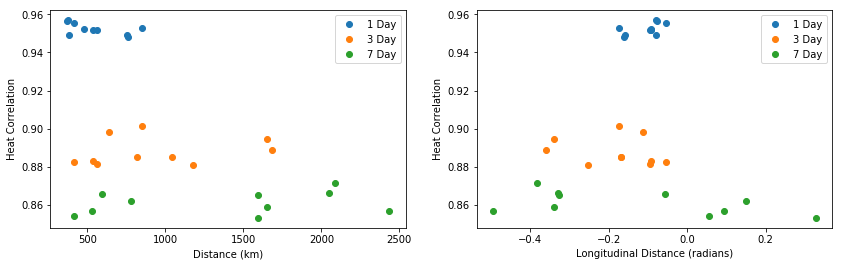

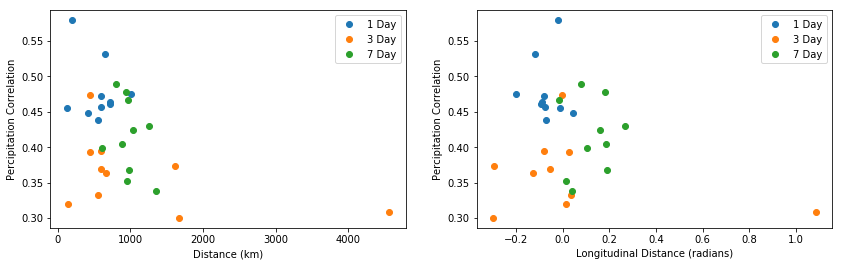

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,4))

day1 = corr_df[corr_df['Delay'] == 1].nlargest(10,'Heat_Correlation')[['Heat_Correlation','Distance']]
day3 = corr_df[corr_df['Delay'] == 3].nlargest(10,'Heat_Correlation')[['Heat_Correlation','Distance']]
day7 = corr_df[corr_df['Delay'] == 7].nlargest(10,'Heat_Correlation')[['Heat_Correlation','Distance']]

ax1.plot(day1['Distance'],day1['Heat_Correlation'],marker='o',linestyle='',label='1 Day')
ax1.plot(day3['Distance'],day3['Heat_Correlation'],marker='o',linestyle='',label='3 Day')
ax1.plot(day7['Distance'],day7['Heat_Correlation'],marker='o',linestyle='',label='7 Day')
ax1.legend()
ax1.set_ylabel("Heat Correlation")
ax1.set_xlabel("Distance (km)")

day1 = corr_df[corr_df['Delay'] == 1].nlargest(10,'Heat_Correlation')[['Heat_Correlation','delta_longitude']]
day3 = corr_df[corr_df['Delay'] == 3].nlargest(10,'Heat_Correlation')[['Heat_Correlation','delta_longitude']]
day7 = corr_df[corr_df['Delay'] == 7].nlargest(10,'Heat_Correlation')[['Heat_Correlation','delta_longitude']]

ax2.plot(day1['delta_longitude'],day1['Heat_Correlation'],marker='o',linestyle='',label='1 Day')
ax2.plot(day3['delta_longitude'],day3['Heat_Correlation'],marker='o',linestyle='',label='3 Day')
ax2.plot(day7['delta_longitude'],day7['Heat_Correlation'],marker='o',linestyle='',label='7 Day')
ax2.legend()
ax2.set_ylabel("Heat Correlation")
ax2.set_xlabel("Longitudinal Distance (radians)")
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,4))

day1 = corr_df[corr_df['Delay'] == 1].nlargest(10,'Percip_Correlation')[['Percip_Correlation','Distance']]
day3 = corr_df[corr_df['Delay'] == 3].nlargest(10,'Percip_Correlation')[['Percip_Correlation','Distance']]
day7 = corr_df[corr_df['Delay'] == 7].nlargest(10,'Percip_Correlation')[['Percip_Correlation','Distance']]

ax1.plot(day1['Distance'],day1['Percip_Correlation'],marker='o',linestyle='',label='1 Day')
ax1.plot(day3['Distance'],day3['Percip_Correlation'],marker='o',linestyle='',label='3 Day')
ax1.plot(day7['Distance'],day7['Percip_Correlation'],marker='o',linestyle='',label='7 Day')
ax1.legend()
ax1.set_ylabel("Percipitation Correlation")
ax1.set_xlabel("Distance (km)")

day1 = corr_df[corr_df['Delay'] == 1].nlargest(10,'Percip_Correlation')[['Percip_Correlation','delta_longitude']]
day3 = corr_df[corr_df['Delay'] == 3].nlargest(10,'Percip_Correlation')[['Percip_Correlation','delta_longitude']]
day7 = corr_df[corr_df['Delay'] == 7].nlargest(10,'Percip_Correlation')[['Percip_Correlation','delta_longitude']]

ax2.plot(day1['delta_longitude'],day1['Percip_Correlation'],marker='o',linestyle='',label='1 Day')
ax2.plot(day3['delta_longitude'],day3['Percip_Correlation'],marker='o',linestyle='',label='3 Day')
ax2.plot(day7['delta_longitude'],day7['Percip_Correlation'],marker='o',linestyle='',label='7 Day')
ax2.legend()
ax2.set_ylabel("Percipitation Correlation")
ax2.set_xlabel("Longitudinal Distance (radians)")
plt.show()

From the above plots we can see pick out a few patterns. 

Firstly, temperature is more highly correlated between locations than percipitation. Even over several days, heat in one location is more predictive of heat in another location than percipitation is predictive.  This makes sense as high temperature is not necessarily as impacted by weather patterns as it is by location.

Secondly, as expected correlation for all both absolute distance and longitudinal distance for both rain and heat drops as the temporal distance between increase. Ie. if more time passes after a measurment, the less information you can predict about a future measurement.  This is roughly a statement saying that weather patterns disperse.

Thridly, higher correlations for short temporal delays are more likely to be between close locations.  You can see the blue dots (1 day delay) are generally closer to zero distance than 3 days and subsequently 7 days. This is particularly evident in graph 1 where the heat correlation for 1 day is between 400-900km, for 3 days 500-1700km, and 7 days 400-2400km.

Finally, if we plot correlations vs longitudindal distance rather than absolute distance we can clearly see that the data points are biased to the left of 0 meaning that correlations are highest when an airport has a more negative longitude than the one it is correlated with at a later time. Ie weather in the west is predictive of weather in the east, which we know is how weather systems in the US generally move.